# Tutorial on using the shooting method

## Summary

This tutorial demonstrates how to use the shooting method to find
MOTSs (marginally outer trapped surfaces) and
MOTOSs (marginally outer trapped open surfaces)
using the shooting method as implemented in the MOTS Finder project.
To this end, we will consider Brill-Lindquist initial data [1] and
find a number of such surfaces numerically.

At the end, we will take one of the closed surfaces (i.e. a MOTS)
and convert it to a spectral surface representation so that it can
be used with the rest of the MOTS Finder infrastructure.
In particular, this will allow us to evaluate physical quantities
such as the area and the MOTS stability spectrum.


### Prerequisites

Though not strictly required, you may benefit from a general understanding
of the MOTS Finder project by looking at one of the previous tutorials
such as [Example: MOTSs in Brill-Lindquist initial data](examples_bl.md).


### References

[1] Brill, Dieter R., and Richard W. Lindquist. "Interaction energy in geometrostatics." Physical Review 131.1 (1963): 471.

## Contents

* [1. Initialization](#1.-Initialization)
* [2. Create the slice metric](#2.-Create-the-slice-metric)
* [3. Our first MOTSodesics](#3.-Our-first-MOTSodesics)
* [4. Finding a MOTS](#4.-Finding-a-MOTS)
* [5. Convert to spectral representation](#5.-Convert-to-spectral-representation)

## 1. Initialization

Before we can use the MOTS Finder classes we need to load the required modules.

In [1]:
%matplotlib inline
import sys
import os.path as op

# Change the path to where the code is located.
sys.path.append(op.expanduser('~/src/distorted-motsfinder-public'))

import numpy as np

from motsfinder.metric import BrillLindquistMetric
from motsfinder.axisym.shooting import shooting_method, get_termination_reason
from motsfinder.axisym.curve import ParametricCurve
from motsfinder.axisym.findmots import GeneralMotsConfig, find_mots
from motsfinder.exprs import SineSeries, CosineSeries
from motsfinder.numutils import clip
from motsfinder.ipyutils import plot_data, wrap_simple_plot_ctx
from motsfinder.ipyutils import add_zero_vline, unify_axes_ranges

## 2. Create the slice metric

Here we create a $3$-metric for the Brill-Lindquist slice.
The two black holes are chosen to be very close together in order
to have a common apparent horizon.

In [2]:
# Brill-Lindquist metric of two non-spinning black holes
# with unequal masses at rest.
g = BrillLindquistMetric(d=0.65, m1=0.2, m2=0.8)

## 3. Our first MOTSodesics

We start by shooting off a MOTSodesic from the $z$-axis.
Since this example will not close the curve on the $z$-axis,
we will here get an open surface, i.e. a MOTOS.
The following cell shows how to use the shooting method
and how to obtain and plot points along the solution curve.

Handling departure from z-axis...
  Initial conditions changed:
    z0    += -1.8737789098111080e-12
    x0    += 9.9999999999999995e-07
    P_dot += -1.0934586569533167e-12
    Z_dot += -8.8630715847381426e-07
A termination event occurred.
Curve left the coordinate domain radius of 3.0.


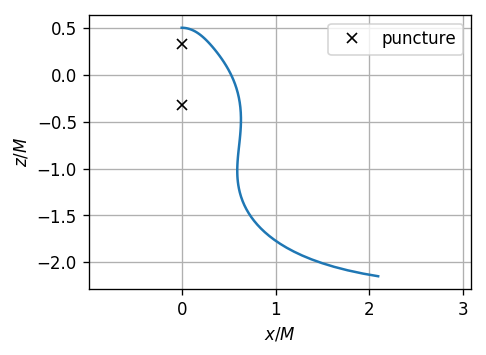

In [3]:
# This shoots off a MOTSodesic from the z-axis.
sol = shooting_method(
    metric=g, max_domain=3.0, verbose=True,
    z0=0.5,
)

# The integration points for the x- and z-axis can be retrieved as follows.
X, Z, _, _ = sol.y

# Plot the points we integrated.
plot_opts = dict(
    figsize=(3.6, 3.6), dpi=120, subplot_kw=dict(aspect="equal"),
    equal_lengths=True, pad="20%", #usetex=True,
)
with wrap_simple_plot_ctx(plot_opts) as (ax, kw):
    plot_data(X, Z, xlabel="$x/M$", ylabel="$z/M$", l='-', **kw)
    plot_data([0, 0], [g.d/2, -g.d/2], 'xk', label="puncture", **kw)

Let's shoot off a few more MOTSodesics and see how they behave.

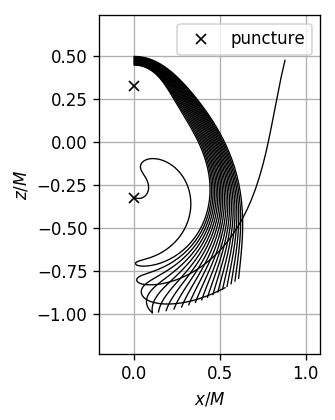

In [4]:
plot_opts = dict(
    figsize=(3.6, 3.6), dpi=120, subplot_kw=dict(aspect="equal"),
    equal_lengths=True, ypad="10%", #usetex=True,
)
with wrap_simple_plot_ctx(plot_opts) as (ax, kw):
    for z0 in np.linspace(0.45, 0.5, 20):
        sol = shooting_method(
            metric=g, max_domain=1.0, verbose=False, z0=z0,
        )
        X, Z, _, _ = sol.y
        plot_data(X, Z, xlabel="$x/M$", ylabel="$z/M$", l='-k', lw=0.8, **kw)
    plot_data([0, 0], [g.d/2, -g.d/2], 'xk', label="puncture", **kw)

As we can see, the first curve (with smallest $z_0 = 0.45$) turns the other way
when nearing the $z$-axis at about $z \approx -0.75$, so there should be something
interesting somewhere between this and the next one.

**NOTE:** It may seem that this first curve closes off by hitting the $z$-axis.
However, it actually hits the puncture. Since this puncture is an asymptotically
flat region, the MOTSodesic is, in fact, open and just travels to infinity like
the others.

## 4. Finding a MOTS

Based on the above results, we tweak the initial $z$-coordinate $z_0$
until the curve closes by hitting the $z$-axis.

This can be done manually with two simple steps:

1. Choose a maximum proper length `s_max` only *slightly* longer than needed.
2. Close in on the $z_0$-range until we hit the axis.

### 4.1 Step 1: Choose `s_max`

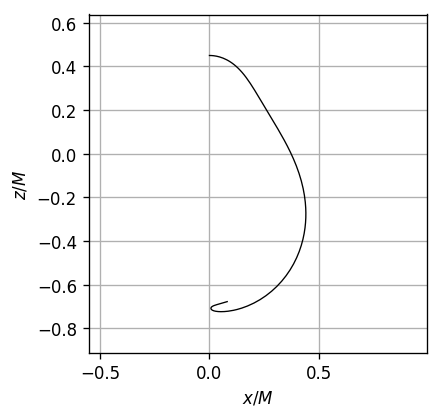

In [5]:
s_max = 7.3 # <-- tweak this value until the curve ends like in this example

sol = shooting_method(
    metric=g, max_domain=1.0, verbose=False, z0=0.45, s_max=s_max,
)
X, Z, _, _ = sol.y
plot_data(
    X, Z, xlabel="$x/M$", ylabel="$z/M$", l='-k', lw=0.8,
    figsize=(3.6, 3.6), dpi=120, subplot_kw=dict(aspect="equal"),
    equal_lengths=True, ypad="10%", #usetex=True,
)

### 4.2 Step 2: Try to hit the $z$-axis

MOTS found!
  z0 = 0.4510025


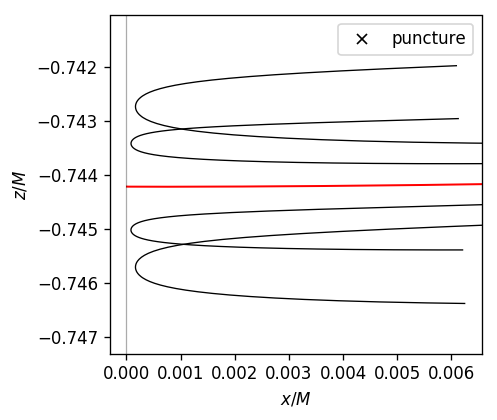

In [6]:
# tweak these two values
z0_min = 0.45098
z0_max = 0.451025
s_max = 6.92 # <-- might tweak too in the end

plot_opts = dict(
    figsize=(3.6, 3.6), dpi=120, subplot_kw=dict(aspect="equal"),
    grid=False, pad="5%", #usetex=True,
)
with wrap_simple_plot_ctx(plot_opts) as (ax, kw):
    end_points = []
    for z0 in np.linspace(z0_min, z0_max, 5):
        sol = shooting_method(
            metric=g, max_domain=1.0, verbose=False, z0=z0, s_max=s_max,
        )
        X, Z, _, _ = sol.y
        end_points.append((X[-1], Z[-1]))
        if get_termination_reason(sol) == "axis_hit":
            plot_data(X, Z, xlabel="$x/M$", ylabel="$z/M$", l='-r', lw=1.2, **kw)
            print("MOTS found!")
            print("  z0 = %r" % z0)
            #break
        else:
            plot_data(X, Z, xlabel="$x/M$", ylabel="$z/M$", l='-k', lw=0.8, **kw)
    plot_data([0, 0], [g.d/2, -g.d/2], 'xk', label="puncture", **kw)
    # Tweak plotted region.
    end_points = np.asarray(end_points)
    ax.set_xlim(0, end_points[:, 0].max())
    ax.set_ylim(end_points[:, 1].min(), end_points[:, 1].max())
    add_zero_vline(ax)
    unify_axes_ranges(ax)

The above shows that for $z_0 \approx 0.4510025$ the integration will end
on the axis, i.e. this is a MOTS (or close to one).

## 5. Convert to spectral representation

We will now take the above curve and construct a MOTS in one of the
curve classes of the MOTS Finder. This then allows computing physical
properties on this MOTS.

### 5.1 Preparing the initial guess curve

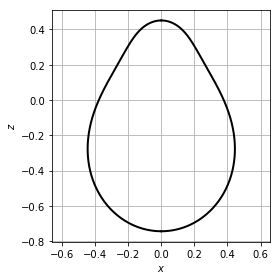

In [7]:
# First, reproduce the MOTS solution.
sol = shooting_method(
    metric=g, max_domain=1.0, verbose=False,
    z0=0.4510025,      # <-- important: use the value found above
    dense_output=True, # <-- needed to interpolate along the solution curve
)
if get_termination_reason(sol) != "axis_hit":
    raise RuntimeError("Not a MOTS")

# This is the interpolating solution function.
f = sol.sol

# Sample the solution as a parametric curve in spectral representation.
a, b = f.t_min, f.t_max
c_ref = ParametricCurve.from_functions(
    x=lambda param: f(a + param/np.pi*(b-a))[0],
    z=lambda param: f(a + param/np.pi*(b-a))[1],
    x_cls=SineSeries, z_cls=CosineSeries,
    num=60, # <-- increase this number for very complicated curves
)
c_ref.plot()

### 5.2 Finding the MOTS with high accuracy

Reparameterization strategy: curv2 (flat space)
Reparameterization options:  {'num': 20, 'coord_space': True}
Reparameterizing reference curve... done after 0:00:00.269176
01: max error at 50 collocation points: 0.0009016243243905597
02: max error at 50 collocation points: 6.096630533747316e-09          (previous Newton step: 1.0)
03: max error at 50 collocation points: 3.552713678800501e-15          (previous Newton step: 1.0)
  Accurate error still 1.62756e-09 > 1e-10... increasing resolution 50 -> 60
04: max error at 60 collocation points: 1.379607872387112e-09          (previous Newton step: 1.0)
05: max error at 60 collocation points: 2.220446049250313e-15          (previous Newton step: 1.0)
  Accurate error = 5.11159e-11 <= 1e-10 at resolution 60


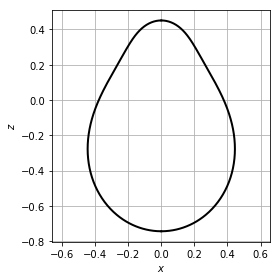

In [8]:
# Now, use the MOTS Finder to "search" for this MOTS.
cfg = GeneralMotsConfig.preset(
    'general',
    hname="outer",  # <-- name used e.g. in saved files
    metric=g, c_ref=c_ref,
    #
    # Shape preparation options:
    ref_num=max(20, int(0.2 * c_ref.num)),
    reparam=("curv2", dict(coord_space=True)), reparam_with_metric=False,
    num=50,         # <-- initial resolution of solution curve
    #
    # Nonlinear search options:
    atol=1e-10,     # <-- can use a smaller tolerance for higher accuracy
    knee_detection=True,
    step_mult="simple", min_step_mult=0.5,
    #
    # Status output options:
    verbose=True,
    #plot_steps=True,
    #
    # Options for saving results:
    #out_folder="data/tutorial/",
    #suffix="example",
)

# Perform the search.
c = find_mots(cfg)

# Plot the found MOTS (no surprises here).
c.plot()

### 5.3 Phyiscal properties

With the MOTS stored in the `c` variable, let's compute a few physical properties.

In [9]:
print("Area: %s" % c.area())
print("Circumferential radius: %s" % c.horizon_radius())

Area: 49.89848922247896
Circumferential radius: 1.9926855261901202


### Invariant angle $\zeta$
The invariant angle [1] is a useful and geometrically defined coordinate along the curve.
For a perfect sphere, we have $\cos\theta = \zeta$.
In the below plots we hence define $\theta := \arccos\zeta$.

**References:**

[1] Ashtekar, Abhay, et al. "Multipole moments of isolated horizons." Classical and Quantum Gravity 21.11 (2004): 2549.

In [10]:
zeta = c.compute_zeta().evaluator()

#### The Ricci scalar

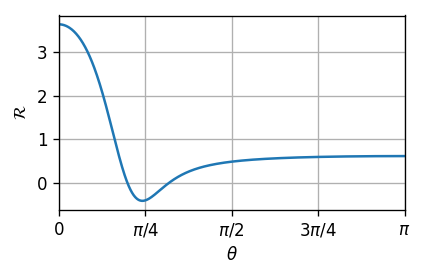

In [11]:
ricci_scalar = CosineSeries.from_function(
    f=c.ricci_scalar, domain=(0, np.pi), num=c.num, lobatto=False,
).evaluator()
params = np.linspace(0, np.pi, 500) # points in internal curve parameter
plot_data(
    [np.arccos(clip(zeta(param), -1, 1)) for param in params],
    [ricci_scalar(param) for param in params],
    xlabel=r"$\theta$", ylabel=r"$\mathcal{R}$", l='-',
    pi_xticks=dict(major=4),
    figsize=(3.6, 2.4), dpi=120, #usetex=True,
)

#### The MOTS stability spectrum

In [12]:
_, spectrum = c.stability_parameter(
    m_max=10, m_terminate_index=None,
    full_output=True
)
spectrum.print_max_l = 5
print(spectrum)

Principal eigenvalue: 0.1826341545492263
Computed spectrum:
l= 0: 0.182634
l= 1: 0.657065, 0.748038, 0.748038
l= 2: 1.5753, 1.62363, 1.62363, 1.95762, 1.95762
l= 3: 2.84504, 2.93632, 2.93632, 3.40396, 3.40396, 3.7466, 3.7466
l= 4: 4.48209, 4.65293, 4.65293, 5.20587, 5.20587, 5.79202, 5.79202, 6.12491, 6.12491
l= 5: 6.5398, 6.75438, 6.75438, 7.3674, 7.3674, 8.18874, 8.18874, 8.75571, 8.75571, 9.09722, 9.09722
...

